## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability



In [2]:
#import important Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [3]:
# load datasets
df=pd.read_csv('ab_data.csv')

# read dataset
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
#checking the info of the data and look for instances of missing or possibly errant data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 7.9+ MB


In [5]:
#The number of rows in the dataset.
df.shape[0]

294478

In [6]:
#The number of unique users in the dataset.
df.user_id.nunique()

290584

In [7]:
#The proportion of users converted.
df.converted.mean()

0.11965919355605512

In [8]:
#the rows have missing values
df.isnull().sum()
#there is no missing values

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

###  messy data

In [9]:
#The number of times the `new_page` and `treatment` don't line up.
not_line_up=len(df.query('group =="treatment" & landing_page !="new_page"')) + len(df.query('group  !="treatment" & landing_page =="new_page"'))
not_line_up

3893

- clean messy data

In [10]:
#create a new dataframe in which old_page and control line up.
df_1= df.query('group == "control" & landing_page == "old_page"')

#create a new dataframe in which new_page and treatment line up.
df_2 = df.query('group == "treatment" & landing_page == "new_page"')

#append rows of df_1 to the end of df_2, returning a new dataframe 
#in which  treatment is aligned with new_page, and control is aligned with old_page.
df2 = df_2.append(df_1,ignore_index=True)



# remove rows
#df2 = df.drop(df[((df.group == 'control') & (df.landing_page == 'new_page')) | 
               #  ((df.group == 'treatment') & (df.landing_page == 'old_page'))].index)
    

In [11]:
# show the new dataset
df2.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [13]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

In [14]:
#The number of unique users in df2 dataset
df2.user_id.nunique()

290584

In [15]:
#The number of unique in df2 dataset
df2.nunique()
#There is one user_id repeated in df2

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [16]:
#show user_id repeated in df2
df2[df2.duplicated(['user_id'], keep=False)]


,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
#information found above
"""
For user_id = 773192 
all things are similar except timestamp
rows 1899 and 2893
"""

'\nFor user_id = 773192 \nall things are similar except timestamp\nrows 1899 and 2893\n'

In [18]:
# Remove one of the rows with a duplicate user_id, but keep your dataframe as df2.
df2.drop_duplicates(['user_id'], inplace=True)

In [19]:
#verify if number of rows have been drop by one
df2.nunique()

user_id         290584
timestamp       290584
group                2
landing_page         2
converted            2
dtype: int64

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
#calculate the averga of the converted column 
df2.converted.mean()


# divide the number of converted by the total number of users in df2
#df2.converted.value_counts()[1] / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
#calculate the averga of the converted column in the control group
df2.query('group=="control"').converted.mean()


#df2.groupby('group').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
#calculate the averga of the converted column in the treatment group
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [23]:
# divide total users in new_page by the total users in df2
#df2.query('landing_page =="new_page"').landing_page.count()/ df2.shape[0]
df2.landing_page.value_counts()[0]/df2.shape[0]

0.5000619442226688

In [24]:
# probability that an individual received the old page
df2.landing_page.value_counts()[1]/df2.shape[0]

0.4999380557773312

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.



- Based on the total users that converted, there is a slim higher number of people that converted in the control group VS  the treatment group.
- The percentage of converted in the control is 12.04% and converted in the treatment group is 11.88%.
- The percentage of  received the new page is 50.0% and he percentage of  received the old page is 49.9% so there is slim higher help in rise the converted in new page 



- The difference is very small so I do not think there is  enough sufficient evidence to say that  a certain page that will convert more users.






<a id='ab_test'></a>
### Part II - A/B Test
`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: 𝑝
new
​
 −𝑝 
old
​
 ≤0$$
$$H_1: 𝑝 
new
​
 −𝑝 
old
​
 >0$$

a. What is the **convert rate** for $p_{new}$ under the null? 

In [25]:
#calculate the mean of the converted in new page
p_new = df2.converted.mean()
p_new


0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [26]:
# calculate the mean of the converted in old page
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [27]:
# count the total number of new page lands
n_new = df2.landing_page.value_counts()[0]
n_new

145310

d. What is $n_{old}$?

In [28]:
# count the total number of old page lands
n_old = df2.landing_page.value_counts()[1]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted= df2.query('landing_page == "new_page"').converted.mean()
new_page_converted
# randomly simulate new page landings using random.choice and p_new
#new_page_converted = np.random.choice([0,1], size=n_new ,p=[p_new,1 - p_new])
#new_page_converted.mean()

0.11880806551510564

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted=df2.query('landing_page == "old_page"').converted.mean()
old_page_converted
# randomly simulate old page landings using random.choice and p_old
#old_page_converted = np.random.choice([0,1], size=n_old ,p=[p_old,1 - p_old])
#old_page_converted.mean()

0.1203863045004612

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [31]:

# compute observed difference in convert rate
obs_diff=new_page_converted - old_page_converted

# display observed difference
obs_diff

-0.0015782389853555567

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [32]:
p_diffs =[]
size = df2.shape[0]
for _ in range (10000):
    b_samp = df2.sample(size, replace=True)
    new_page_converted= b_samp.query('landing_page == "new_page"').converted.mean()
    old_page_converted=b_samp.query('landing_page == "old_page"').converted.mean()
    p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

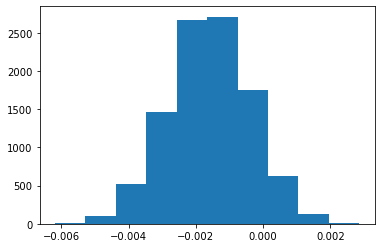

In [33]:
# convert to numpy array
p_diffs = np.array(p_diffs)

# plot distribution
plt.hist(p_diffs);

In [34]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

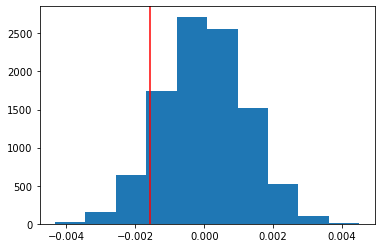

In [35]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(obs_diff, c='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
# compute p value
(null_vals > obs_diff).mean()

#our p-value 90%

0.9048

In [36]:

(p_diffs > obs_diff).mean()
# proportion of the p_diffs greater than the actual difference observed is 50%

0.5044

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- a **p-value is 0.90**, the difference in the conversion rate for the control and treatment groups does NOT appear to be significant. Since the p-value is far greater than the typical $\alpha$ level of 0.05 in business studies. (An $\alpha$ level of 0.05 indicates that we have a 5% chance of committing a Type I error if the null is true.) As such, **we would fail to reject the null hypothesis**.

And based on these results, **It looks like the company should stay with the old page as there is No conversion advantage with new web page**. Although old and new web pages perform almost similarly, old web page(as the numbers show) performed slightly better

In [37]:
import statsmodels.api as sm
#Calculate number of rows for old and new
convert_old = df2.query('landing_page == "old_page" & converted == "1"').count()[0]
convert_new = df2.query('landing_page == "new_page" & converted == "1"').count()[0]
n_old = df2.landing_page.value_counts()[1]
n_new = df2.landing_page.value_counts()[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)


Use stats.proportions_ztest to compute your test statistic and p-value

In [38]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [39]:
from scipy.stats import norm

print(norm.cdf(z_score)) # Tells us how significant our z-score is
print(norm.ppf(1-(0.05/2))) # Tells us what our critical value at 95% confidence is

0.09494168724097551
1.959963984540054


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- The z-score and the p_value mean that doesn't reject the Null. The Null being the converted rate of the old_page is the same or greater than the converted rate of the new_page. 

-  The z-score of -1.31092419842 is less than the critical value of 1.95996398454. So, we fail to reject the null hypothesis.
- Old Page (17489/145274) is statistically different and slightly better than New Page (17264/145310). However, we would expect their long-term performance to be different from one another.

- The p_value is 0.90 and is higher than 0.05 significance level.we fail to reject the null hypothesis. That means we can not be confident with a 95% confidence level that the converted rate of the new page is larger than the old page.
- These values agree with the findings in parts j and k .

<a id='regression'></a>
### Part III - A regression approach

`Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**- The dependent variable is a binary variable (converted).
we will use a logistic regression.**


**- Response variable is categorical**


Create dummy variables

In [69]:
# Make 1 for new_page and treatment
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment'] 
df2

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1
...,...,...,...,...,...,...,...
290580,718310,2017-01-21 22:44:20.378320,control,old_page,0,0,1
290581,751197,2017-01-03 22:28:38.630509,control,old_page,0,0,1
290582,945152,2017-01-12 00:51:57.078372,control,old_page,0,0,1
290583,734608,2017-01-22 11:45:03.439544,control,old_page,0,0,1



Instantiate and fit the model

In [70]:
#add an intercept
df2['intercept'] = 1

lm = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = lm.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


 Provide the summary of your model below

In [71]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Aug 2021   Pseudo R-squ.:               8.077e-06
Time:                        14:31:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [72]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

#### What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?


Hyotheses associated with regression model are as follows :
$$H_0: p_{new} - p_{old} = 0 $$$$H_1: p_{new} - p_{old} \neq  0 $$
- The hypotheses associated with Logistic Regression is aimed to determine only one of two possible outcomes: If the conversion rate new page is equal to one of the old page (Null Hypothesis) or it is different (Alternative Hypothsis).

- The p-value associated with ab_page column in this case = 0.190 which is much lower than the p-value calculated using the z-score function that equals to 0.905.

- The p-values are different since we are performing a two-tailed test in Logistic Regression NOT a one-tailed test as done before.

- In Logistic Regression, the returned p-value associated with ab_page column,that is equal to 0.190, is still greater than the typical $\alpha$ level of 0.05 in business studies.Therefore, we would fail to reject the null hypothesis.


#### Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- Other factors that influence whether an individual converts could be age.
- Older users may prefer more information on the pages as opposed to a kid, where they may prefer more pictures and a more casual theme. 
- Adding more factors into the regression model will increase or decrease confidence intervals.
*A disadvantage of multiple factors in a logistic regression model is that it reduces the power of analysis.

#### Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives.  



In [95]:
#Read in the countries.csv Dataset 
countries_df = pd.read_csv('./countries.csv')

countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [96]:
# Adding an additional Explanatory variable 'country' to the mode

df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [97]:
#checking the unique values of country column
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [98]:
#checking the number of users in each country 
df_new['country'].astype(str).value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [99]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

df_new.head()


,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [100]:
#Fit Your Logistic Model And Obtain the Results
df_new['intercept'] = 1

lm = sm.Logit(df_new['converted'], df_new[['intercept', 'CA','US', 'ab_page']])
results = lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 11 Aug 2021   Pseudo R-squ.:               2.323e-05
Time:                        14:45:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  



In [101]:
#create the necessary additional columns
df_new['CA_page'] = df_new['CA'] * df_new['ab_page']
df_new['US_page'] = df_new['US'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,CA_page,US_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [102]:
# Fit the Logistic Model 
df_new['intercept'] = 1

log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA','US', 'ab_page','CA_page','US_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Aug 2021   Pseudo R-squ.:               3.482e-05
Time:                        14:45:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA_page       -0.0783      0.057     -1.378      0.168      -0.190       0.033
US_page       -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

In [103]:
np.exp(results.params)

intercept    0.136392
CA           0.988285
US           1.005761
ab_page      1.010893
CA_page      0.924703
US_page      0.969090
dtype: float64

#### Summary: 
the p-values associated with the variables is higher than  the significance level of 0.05 ($\alpha$ level). This means that we fail to reject the Null Hypothesis Moreover, there is NO sufficient evidence suggesting that there is an interaction between country and page received that will predict whether a user converts or not.



<a id='conclusions'></a>
## Conclusions
Based on the statistical tests we used,p-values, the Z-test, logistic regression model, and actual difference observed, the results have shown that the new and old page have an approximately equal chance of converting users. We fail to reject the null hypothesis. I recommend to the e-commerce company to keep the old page. This will save time and money on creating a new page.

 